In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly
import pyarrow.parquet as pq
import seaborn as sns
import toml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing
from sklearn.metrics import (
    auc,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

sys.path.append("..")
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

sys.path.append("../..")
from utils.utils import df_stats

In [2]:
# Import Data
# set data file path under pathlib path for multi-system use
file_path = Path(
    "../../../Extracted_Features_(CSV_files)/SHSY5Y_preprocessed_df_sc_norm.parquet"
)

df = pq.read_table(file_path).to_pandas()

In [3]:
data = Path("../MLP_utils/config.toml")
config = toml.load(data)
params = Parameters()
params = parameter_set(params, config)
params.MODEL_TYPE

'Multi_Class'

In [4]:
def test_loop(df, output_name, title):
    # Code snippet for metadata extraction by Jenna Tomkinson
    df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

    # define which columns are data and which are descriptive
    df_descriptive = df[df_metadata]
    df_values = df.drop(columns=df_metadata)
    # Creating label encoder
    le = preprocessing.LabelEncoder()
    # Converting strings into numbers
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    )
    # split into X and Y where Y are the predictive column and x are the observable data
    df_values_X = df_values.drop(
        [
            "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
            "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
            "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
            "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
        ],
        axis=1,
    )
    df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    test_data = Dataset_formatter(
        torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
    )

    params.IN_FEATURES = df_values_X.shape[1]
    print("Number of in features: ", params.IN_FEATURES)
    if params.MODEL_TYPE == "Regression":
        params.OUT_FEATURES = 1
    else:
        params.OUT_FEATURES = len(
            df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
        )

    print("Number of out features: ", params.OUT_FEATURES)

    if params.OUT_FEATURES > 2:
        params.MODEL_TYPE = "Multi_Class"
    elif params.OUT_FEATURES == 2:
        params.OUT_FEATURES = params.OUT_FEATURES - 1
        params.MODEL_TYPE = "Binary_Classification"
    elif params.OUT_FEATURES == 1:
        params.MODEL_TYPE = "Regression"
    else:
        pass
    print(params.MODEL_TYPE)

    # convert data class into a dataloader to be compatible with pytorch
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)
    model = optimized_model_create(params, params.MODEL_NAME)
    # calling the testing function and outputting list values of tested model
    if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
        y_pred_list = test_optimized_model(
            model, test_loader, params, model_name=params.MODEL_NAME
        )
    elif params.MODEL_TYPE == "Binary_Classification":
        y_pred_list, y_pred_prob_list = test_optimized_model(
            model, test_loader, params, model_name=params.MODEL_NAME
        )
    else:
        raise Exception("Model type must be specified for proper model testing")

    # un-nest list if nested i.e. length of input data does not match length of output data
    if len(y_pred_list) != len(df_values_Y):
        y_pred_list = un_nest(y_pred_list)
        y_pred_prob_list = un_nest(y_pred_prob_list)
    else:
        pass
    # Call visualization function
    # calling the testing function and outputting list values of tested model
    if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
        confusion_matrix_df = results_output(
            y_pred_list,
            df_values_Y,
            params,
            test_name=f"{output_name}_all_testing",
            model_name=params.MODEL_NAME,
            title=title,
        )
    elif params.MODEL_TYPE == "Binary_Classification":
        results_output(
            y_pred_list,
            df_values_Y,
            params,
            y_pred_prob_list,
            test_name=f"{output_name}_all_testing",
            model_name=params.MODEL_NAME,
            title=title,
        )
    else:
        raise Exception("Model type must be specified for proper model testing")

In [5]:
df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()

array(['media ctr_0_Media ctr_0.0', 'DMSO_0.100_DMSO_1.0',
       'DMSO_0.100_Z-VAD-FMK_100.0', 'DMSO_0.100_Z-VAD-FMK_30.0',
       'DMSO_0.100_DMSO_0.025', 'Thapsigargin_1.000_DMSO_0.025',
       'Thapsigargin_10.000_DMSO_0.025', 'Topotecan_5.000_DMSO_0.025',
       'Topotecan_10.000_DMSO_0.025', 'Topotecan_20.000_DMSO_0.025',
       'LPS_0.010_DMSO_0.025', 'LPS_0.100_DMSO_0.025',
       'LPS_1.000_DMSO_0.025', 'LPS_10.000_DMSO_0.025',
       'LPS_10.000_Disulfiram_0.1', 'LPS_10.000_Disulfiram_1.0',
       'LPS_10.000_Disulfiram_2.5',
       'LPS_Nigericin_100.000_1.0_DMSO_0.025',
       'LPS_Nigericin_100.000_3.0_DMSO_0.025',
       'LPS_Nigericin_100.000_10.0_DMSO_0.025',
       'Disulfiram_0.100_DMSO_0.025', 'Disulfiram_1.000_DMSO_0.025',
       'Disulfiram_2.500_DMSO_0.025', 'H2O2_100.000_DMSO_0.025',
       'LPS_10.000_Z-VAD-FMK_100.0', 'LPS_100.000_DMSO_0.025',
       'LPS_Nigericin_1.000_1.0_DMSO_0.025',
       'LPS_Nigericin_1.000_3.0_DMSO_0.025',
       'LPS_Nigericin_1.000_1

In [6]:
paired_treatment_list = [
    ["LPS_100.000_DMSO_0.025", "H2O2_100.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    [
        "Thapsigargin_1.000_DMSO_0.025",
        "H2O2_100.000_Z-VAD-FMK_100.0",
        "DMSO_0.100_DMSO_0.025",
    ],
    ["LPS_0.100_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    ["LPS_1.000_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    ["LPS_10.000_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    [
        "LPS_100.000_DMSO_0.025",
        "Thapsigargin_1.000_DMSO_0.025",
        "DMSO_0.100_DMSO_0.025",
    ],
    ["LPS_0.100_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    ["LPS_1.000_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    [
        "LPS_10.000_DMSO_0.025",
        "Thapsigargin_10.000_DMSO_0.025",
        "DMSO_0.100_DMSO_0.025",
    ],
    [
        "LPS_100.000_DMSO_0.025",
        "Thapsigargin_10.000_DMSO_0.025",
        "DMSO_0.100_DMSO_0.025",
    ],
]

DMSO_0.100_DMSO_0.025 H2O2_100.000_DMSO_0.025 LPS_100.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.59      0.98      0.74     35643
           1       0.03      0.02      0.02     26900
           2       0.00      0.00      0.00     15987

    accuracy                           0.45     78530
   macro avg       0.21      0.33      0.26     78530
weighted avg       0.28      0.45      0.34     78530

Precision for class 0: 0.5943854170202655
Recall for class 0: 0.9825211121398311
Precision for class 1: 0.031963186369006906
Recall for class 1: 0.019107806691449816
Precision for class 2: 0.0033984706881903144
Recall for class 2: 0.0007506098705197974
3


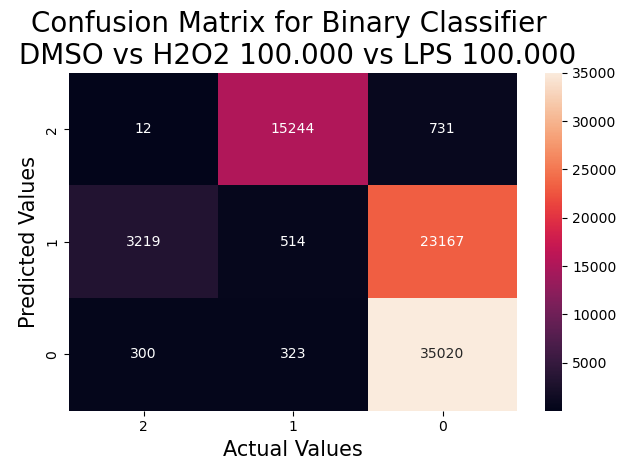

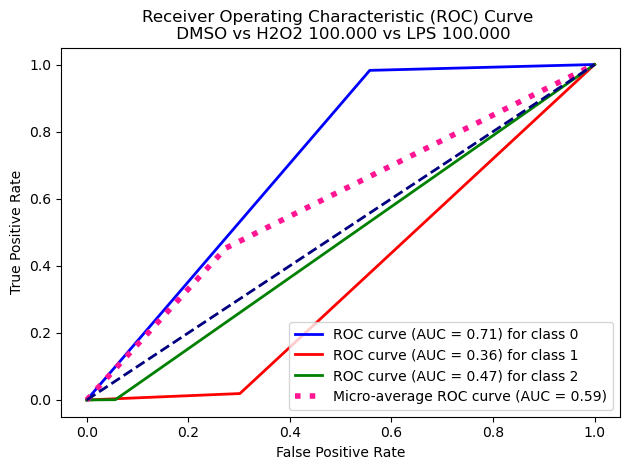

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025 H2O2_100.000_Z-VAD-FMK_100.0
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.67      0.98      0.80     35643
           1       0.22      0.01      0.02     14747
           2       0.81      0.67      0.73     13766

    accuracy                           0.69     64156
   macro avg       0.57      0.55      0.52     64156
weighted avg       0.60      0.69      0.60     64156

Precision for class 0: 0.6709197846619538
Recall for class 0: 0.9825211121398311
Precision for class 1: 0.2215568862275449
Recall for class 1: 0.010035939513121313
Precision for class 2: 0.8135683287574174
Recall for class 2: 0.6672962371059131
3


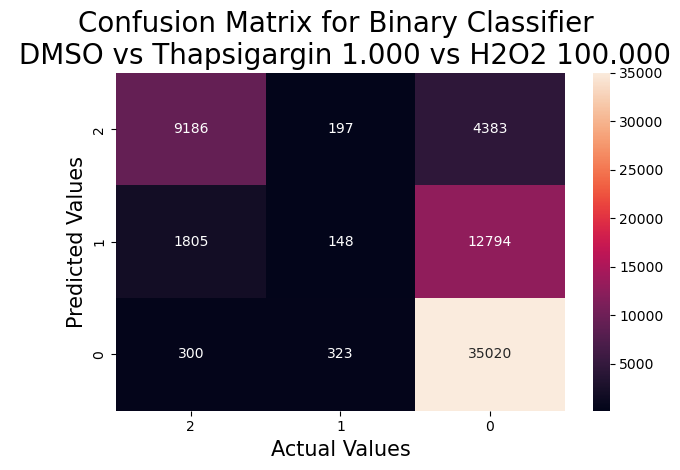

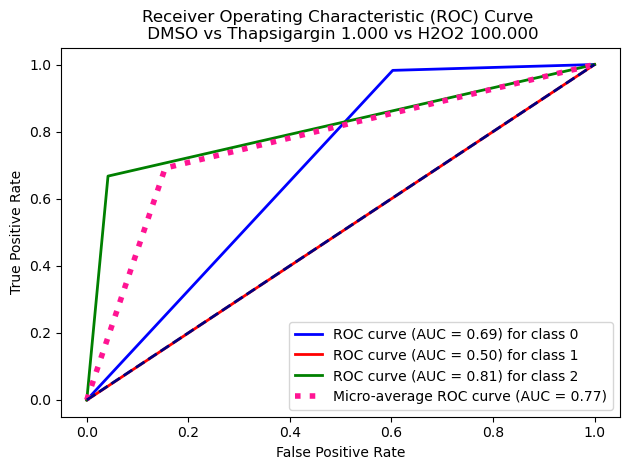

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025 LPS_0.100_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.63      0.98      0.77     35643
           1       0.61      0.05      0.08     17510
           2       0.94      0.67      0.78     13766

    accuracy                           0.67     66919
   macro avg       0.72      0.57      0.54     66919
weighted avg       0.69      0.67      0.59     66919

Precision for class 0: 0.6274861135997133
Recall for class 0: 0.9825211121398311
Precision for class 1: 0.6051632498101747
Recall for class 1: 0.04551684751570531
Precision for class 2: 0.9381127450980392
Recall for class 2: 0.6672962371059131
3


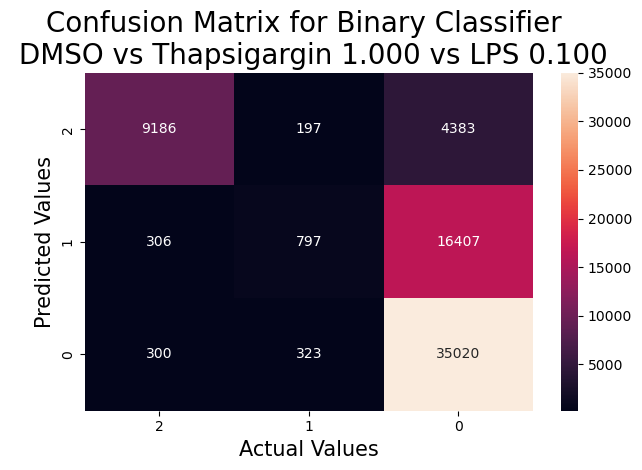

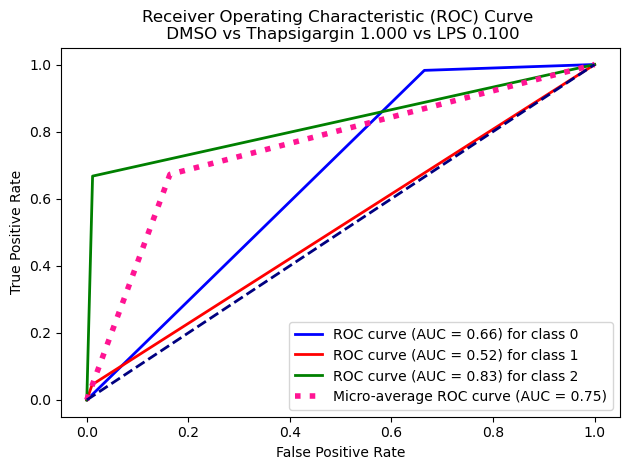

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025 LPS_1.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.64      0.98      0.78     35643
           1       0.58      0.04      0.08     16458
           2       0.91      0.67      0.77     13766

    accuracy                           0.68     65867
   macro avg       0.71      0.56      0.54     65867
weighted avg       0.68      0.68      0.60     65867

Precision for class 0: 0.6422859658132198
Recall for class 0: 0.9825211121398311
Precision for class 1: 0.5789473684210527
Recall for class 1: 0.04344391785150079
Precision for class 2: 0.908785120696478
Recall for class 2: 0.6672962371059131
3


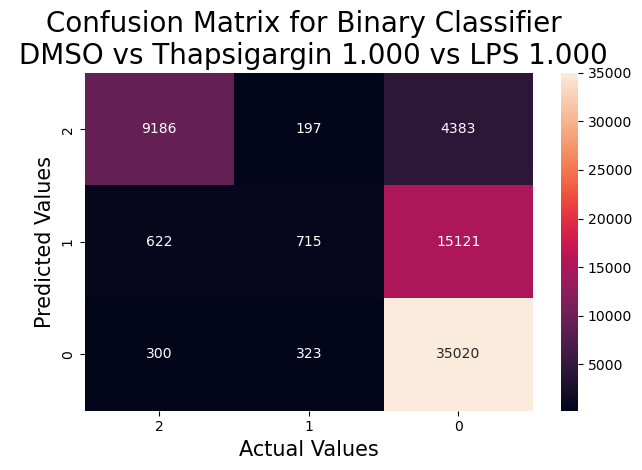

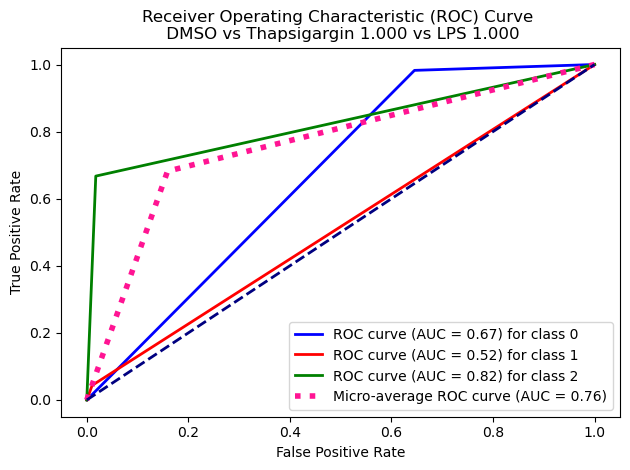

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025 LPS_10.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.64      0.98      0.77     35643
           1       0.61      0.05      0.09     16810
           2       0.92      0.67      0.77     13766

    accuracy                           0.68     66219
   macro avg       0.72      0.57      0.55     66219
weighted avg       0.69      0.68      0.60     66219

Precision for class 0: 0.6376896043119616
Recall for class 0: 0.9825211121398311
Precision for class 1: 0.6142433234421365
Recall for class 1: 0.04925639500297442
Precision for class 2: 0.9228450874020494
Recall for class 2: 0.6672962371059131
3


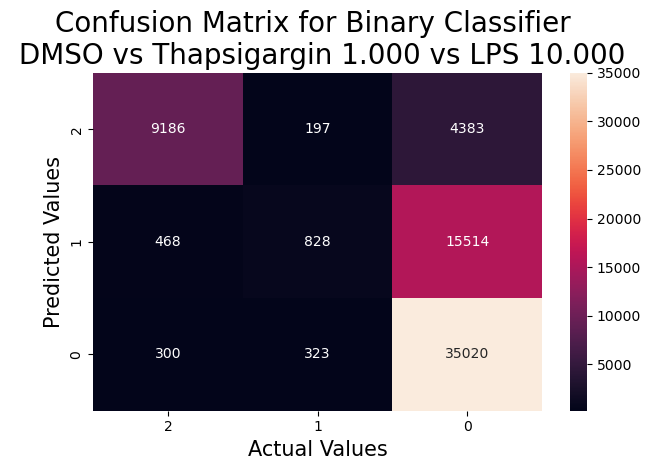

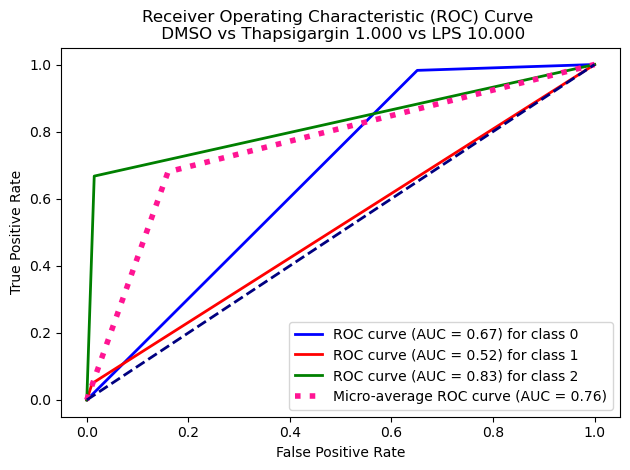

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025 LPS_100.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.87      0.98      0.92     35643
           1       0.97      0.95      0.96     15987
           2       0.97      0.67      0.79     13766

    accuracy                           0.91     65396
   macro avg       0.94      0.87      0.89     65396
weighted avg       0.92      0.91      0.90     65396

Precision for class 0: 0.8725768674938954
Recall for class 0: 0.9825211121398311
Precision for class 1: 0.9670134483633596
Recall for class 1: 0.9535247388503159
Precision for class 2: 0.967150979153506
Recall for class 2: 0.6672962371059131
3


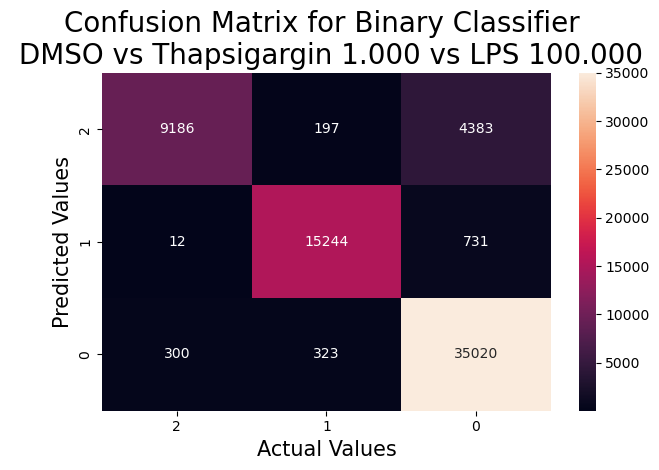

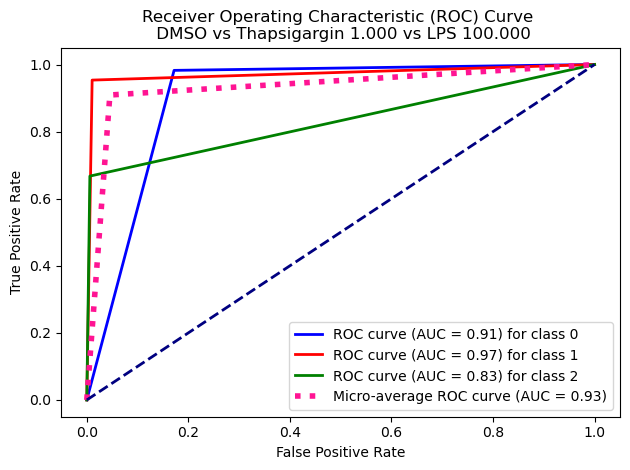

DMSO_0.100_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025 LPS_0.100_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.67      0.98      0.80     35643
           1       0.69      0.05      0.09     17510
           2       0.95      0.95      0.95     13212

    accuracy                           0.73     66365
   macro avg       0.77      0.66      0.61     66365
weighted avg       0.73      0.73      0.64     66365

Precision for class 0: 0.6729826853969291
Recall for class 0: 0.9825211121398311
Precision for class 1: 0.6906412478336221
Recall for class 1: 0.04551684751570531
Precision for class 2: 0.9540003036283589
Recall for class 2: 0.9512564335452619
3


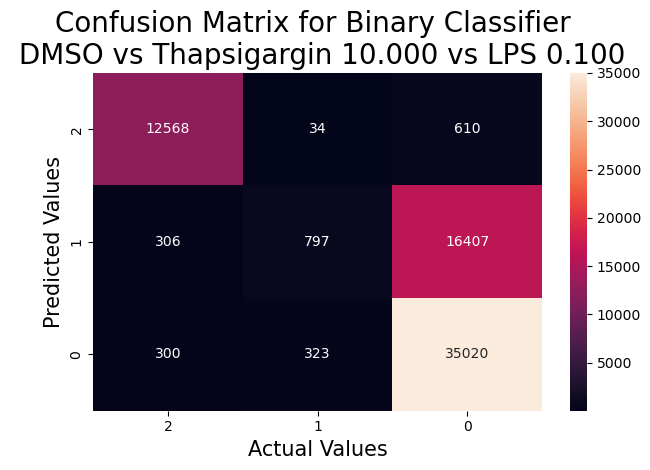

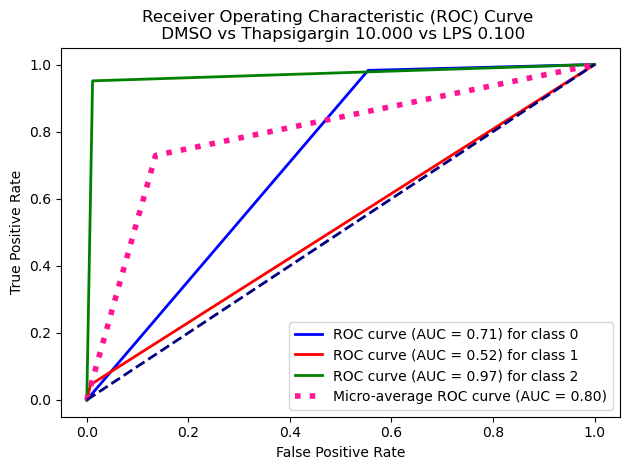

DMSO_0.100_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025 LPS_1.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.69      0.98      0.81     35643
           1       0.67      0.04      0.08     16458
           2       0.93      0.95      0.94     13212

    accuracy                           0.74     65313
   macro avg       0.76      0.66      0.61     65313
weighted avg       0.73      0.74      0.65     65313

Precision for class 0: 0.6900356643218852
Recall for class 0: 0.9825211121398311
Precision for class 1: 0.6669776119402985
Recall for class 1: 0.04344391785150079
Precision for class 2: 0.931653076352854
Recall for class 2: 0.9512564335452619
3


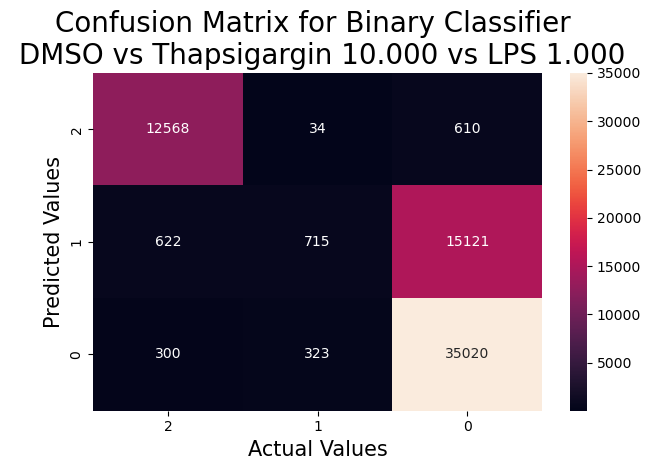

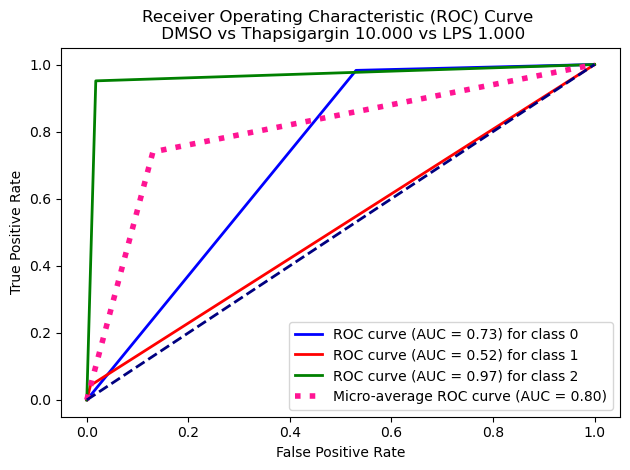

DMSO_0.100_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025 LPS_10.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.68      0.98      0.81     35643
           1       0.70      0.05      0.09     16810
           2       0.94      0.95      0.95     13212

    accuracy                           0.74     65665
   macro avg       0.78      0.66      0.62     65665
weighted avg       0.74      0.74      0.65     65665

Precision for class 0: 0.6847333020491162
Recall for class 0: 0.9825211121398311
Precision for class 1: 0.6987341772151898
Recall for class 1: 0.04925639500297442
Precision for class 2: 0.9424115176964607
Recall for class 2: 0.9512564335452619
3


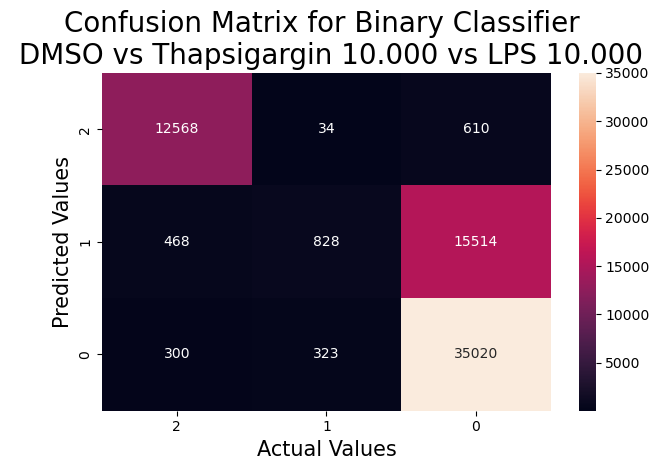

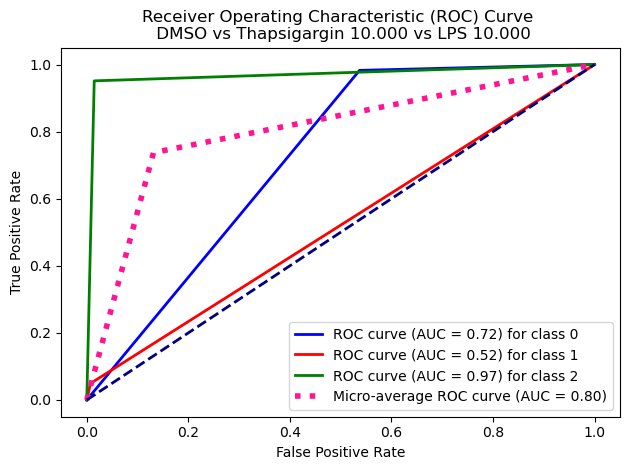

DMSO_0.100_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025 LPS_100.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     35643
           1       0.98      0.95      0.97     15987
           2       0.98      0.95      0.96     13212

    accuracy                           0.97     64842
   macro avg       0.97      0.96      0.97     64842
weighted avg       0.97      0.97      0.97     64842

Precision for class 0: 0.9631198261873984
Recall for class 0: 0.9825211121398311
Precision for class 1: 0.9771168514838793
Recall for class 1: 0.9535247388503159
Precision for class 2: 0.9757763975155279
Recall for class 2: 0.9512564335452619
3


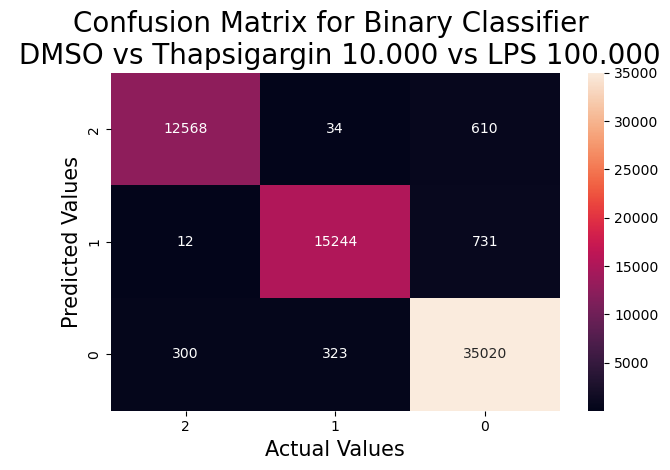

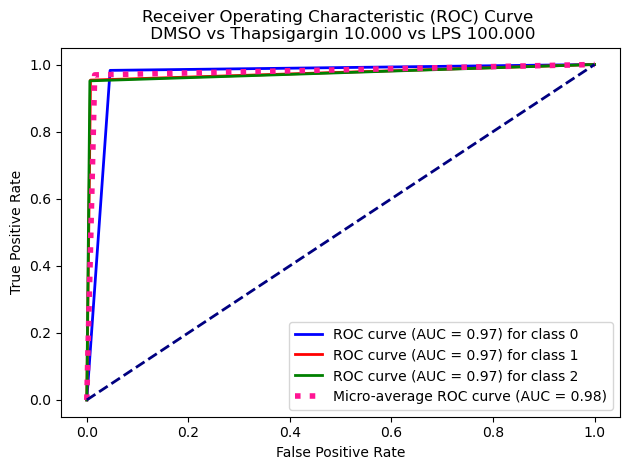

In [7]:
for i, j, k in paired_treatment_list:
    # print(i,j,k)
    test_df = df.query(
        f"oneb_Metadata_Treatment_Dose_Inhibitor_Dose == '{i}' | oneb_Metadata_Treatment_Dose_Inhibitor_Dose == '{j}' | oneb_Metadata_Treatment_Dose_Inhibitor_Dose == '{k}'"
    )
    output_name = (" ").join(
        test_df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )
    print(output_name)
    # title = f'{output_name.split(" ")[0].split("_")[0]} vs {(" ").join(output_name.split(" ")[1].split("_")[:2])}'
    title = f'{output_name.split(" ")[0].split("_")[0]} vs {(" ").join(output_name.split(" ")[1].split("_")[:2])} vs {(" ").join(output_name.split(" ")[2].split("_")[:2])}'

    test_loop(test_df, output_name, title)